<a href="https://colab.research.google.com/github/Deb2003-21/Deb2003-21/blob/main/skin_pox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
joydippaul_mpox_skin_lesion_dataset_version_20_msld_v20_path = kagglehub.dataset_download('joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20')

print('Data source import complete.')


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Augmented Images/Augmented Images/FOLDS_AUG/fold4_AUG/Train/Chickenpox/CHP_19_01_1.jpg
/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Augmented Images/Augmented Images/FOLDS_AUG/fold4_AUG/Train/Chickenpox/CHP_03_01_8.jpg
/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Augmented Images/Augmented Images/FOLDS_AUG/fold4_AUG/Train/Chickenpox/CHP_61_01_8.jpg
/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Augmented Images/Augmented Images/FOLDS_AUG/fold4_AUG/Train/Chickenpox/CHP_41_01_10.jpg
/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Augmented Images/Augmented Images/FOLDS_AUG/fold4_AUG/Train/Chickenpox/CHP_39_01_11.jpg
/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Augmented Images/Augmented Images/FOLDS_AUG/fold4_AUG/Train/Chickenpox/CHP_07_01_11.jpg
/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Augmented I

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [ ]:

# Your existing variables
IMG_SIZE = (224, 224)
BATCH_SIZE = 32



In [ ]:

# Set your desired image limit per class for 'Monkeypox'
IMAGE_LIMIT_MONKEYPOX = 1300

# Update BASE_DIR to point to the directory containing the individual folds
BASE_DIR = os.path.join(joydippaul_mpox_skin_lesion_dataset_version_20_msld_v20_path, 'Augmented Images', 'Augmented Images', 'FOLDS_AUG')

# The loop will now iterate through the individual fold directories (e.g., 'fold_0', 'fold_1')
for fold in sorted(os.listdir(BASE_DIR)):
    fold_path = os.path.join(BASE_DIR, fold)

    # Check if the current item is a directory before proceeding
    if os.path.isdir(fold_path):
        train_dir = os.path.join(fold_path, 'Train')

        print(f"\n📁 Processing fold: {fold}")

        # Check if the train_dir exists before proceeding
        if os.path.exists(train_dir):
            # Create a list to store the image paths for each class in this fold
            all_image_paths = []
            all_labels = []

            # Iterate through the class directories within the 'Train' directory
            for class_name in os.listdir(train_dir):
                class_dir = os.path.join(train_dir, class_name)

                if os.path.isdir(class_dir):
                    image_paths = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, img))]

                    # Limit the number of images if it's the 'Monkeypox' class
                    if class_name == 'Monkeypox' and len(image_paths) > IMAGE_LIMIT_MONKEYPOX:
                        # Randomly sample IMAGE_LIMIT_MONKEYPOX images
                        image_paths = np.random.choice(image_paths, size=IMAGE_LIMIT_MONKEYPOX, replace=False)
                        print(f"  - Limiting 'Monkeypox' images to {IMAGE_LIMIT_MONKEYPOX} in {fold}")

                    # Add the selected image paths and their corresponding labels
                    all_image_paths.extend(image_paths)
                    all_labels.extend([class_name] * len(image_paths))

            # Create a DataFrame for flow_from_dataframe
            if all_image_paths:
                df = pd.DataFrame({'filename': all_image_paths, 'class': all_labels})

                # Define ImageDataGenerator with desired augmentations
                datagen = ImageDataGenerator(
                    preprocessing_function=preprocess_input,
                    rotation_range=30,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    brightness_range=[0.8, 1.2],
                    fill_mode='nearest'
                )

                # Use flow_from_dataframe
                train_data = datagen.flow_from_dataframe(
                    df,
                    x_col='filename',
                    y_col='class',
                    target_size=IMG_SIZE,
                    batch_size=BATCH_SIZE,
                    class_mode='categorical',
                    shuffle=True
                )

                # Get the number of classes from the class_indices attribute of the generator
                num_classes = len(train_data.class_indices)

                print(f"  Found {train_data.samples} images belonging to {num_classes} classes in {train_dir}")

            else:
                print(f"  No images found in {train_dir}")
        else:
            print(f"🚫 Error: Training directory not found: {train_dir}")


📁 Processing fold: fold1_AUG
  - Limiting 'Monkeypox' images to 1300 in fold1_AUG
Found 5990 validated image filenames belonging to 6 classes.
  Found 5990 images belonging to 6 classes in /kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Augmented Images/Augmented Images/FOLDS_AUG/fold1_AUG/Train

📁 Processing fold: fold2_AUG
  - Limiting 'Monkeypox' images to 1300 in fold2_AUG
Found 5878 validated image filenames belonging to 6 classes.
  Found 5878 images belonging to 6 classes in /kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Augmented Images/Augmented Images/FOLDS_AUG/fold2_AUG/Train

📁 Processing fold: fold3_AUG
  - Limiting 'Monkeypox' images to 1300 in fold3_AUG
Found 5822 validated image filenames belonging to 6 classes.
  Found 5822 images belonging to 6 classes in /kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Augmented Images/Augmented Images/FOLDS_AUG/fold3_AUG/Train

📁 Processing fold: fold4_AUG
  - Limiting 'Monkeypox' images to 1300 in 

In [ ]:
#test set and val set

# Assuming original images are within the downloaded dataset path
# IMPORTANT: You might need to adjust the path components ('Original Images', 'Original Images', 'FOLDS')
# based on the actual structure of your dataset within the Kaggle environment.
BASE_DIR2 = os.path.join(joydippaul_mpox_skin_lesion_dataset_version_20_msld_v20_path, 'Original Images', 'Original Images', 'FOLDS')

# If your original images are a separate dataset, you might need to replace the path above
# with something like:
# BASE_DIR2 = '/kaggle/input/your-original-images-dataset-name/Original Images/Original Images/FOLDS'
# Make sure 'your-original-images-dataset-name' is replaced with the actual dataset name.


for fold in sorted(os.listdir(BASE_DIR2)):
    fold_path = os.path.join(BASE_DIR2, fold)
    test_dir = os.path.join(fold_path, 'Test')
    val_dir = os.path.join(fold_path, 'Valid')

    # Add a check to ensure it's a directory before proceeding
    if os.path.isdir(fold_path):
        # Add checks to ensure train_dir, test_dir, and val_dir exist
        if os.path.exists(val_dir):
            val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
            val_data = val_datagen.flow_from_directory(
                val_dir,
                target_size=IMG_SIZE,
                batch_size=BATCH_SIZE,
                class_mode='categorical'
            )
            print(f"Found {val_data.samples} images belonging to {val_data.num_classes} classes in {val_dir}")
        else:
            print(f"🚫 Error: Validation directory not found: {val_dir}")


        if os.path.exists(test_dir):
            test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
            test_data = test_datagen.flow_from_directory(
                test_dir,
                target_size=IMG_SIZE,
                batch_size=BATCH_SIZE,
                class_mode='categorical',
                shuffle=False
            )
            print(f"Found {test_data.samples} images belonging to {test_data.num_classes} classes in {test_dir}")
        else:
            print(f"🚫 Error: Test directory not found: {test_dir}")

    else:
        print(f"Skipping non-directory item: {fold_path}")

Found 144 images belonging to 6 classes.
Found 144 images belonging to 6 classes in /kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold1/Valid
Found 74 images belonging to 6 classes.
Found 74 images belonging to 6 classes in /kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold1/Test
Found 164 images belonging to 6 classes.
Found 164 images belonging to 6 classes in /kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold2/Valid
Found 82 images belonging to 6 classes.
Found 82 images belonging to 6 classes in /kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold2/Test
Found 153 images belonging to 6 classes.
Found 153 images belonging to 6 classes in /kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold3/Valid
Found 64 images belonging to 6 classes.
F


Total image counts per class across all folds (with Monkeypox limit):
Class 'HFMD': 7882 images
Class 'Monkeypox': 6500 images
Class 'Measles': 2618 images
Class 'Healthy': 5656 images
Class 'Chickenpox': 3598 images
Class 'Cowpox': 3220 images


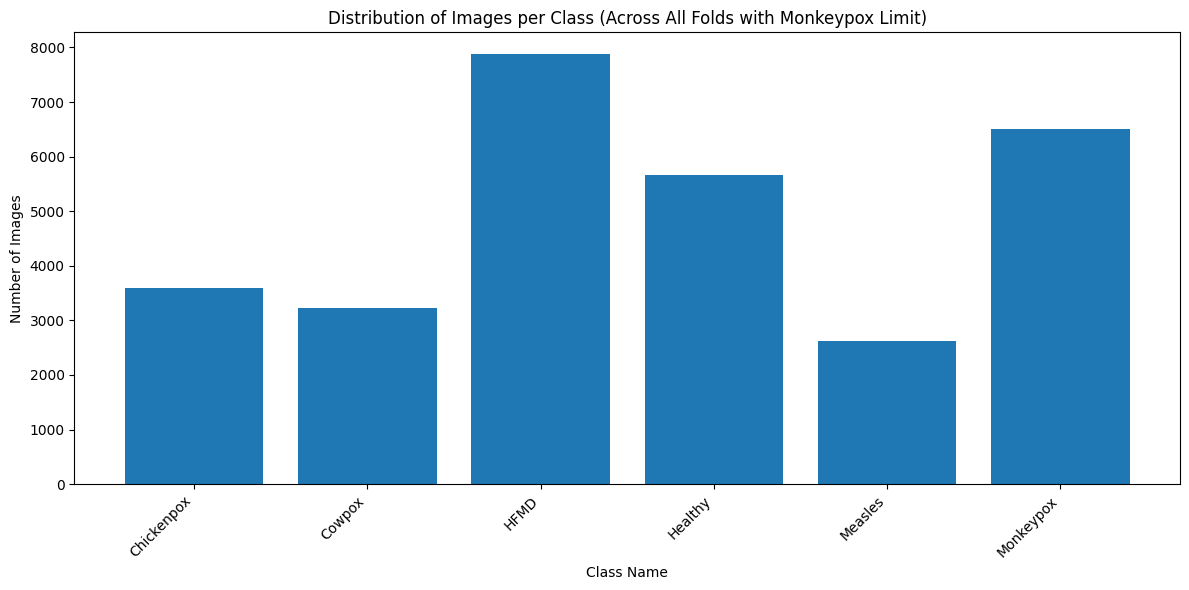

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Set your desired image limit per class for 'Monkeypox'
IMAGE_LIMIT_MONKEYPOX = 1300  # Make sure this matches the limit used for data loading

# Replace with the path to your main directory containing the fold subdirectories
main_directory_path = os.path.join(joydippaul_mpox_skin_lesion_dataset_version_20_msld_v20_path, 'Augmented Images', 'Augmented Images', 'FOLDS_AUG')

class_counts = {}

# Iterate through the fold directories (e.g., fold_0, fold_1, etc.)
for fold_name in sorted(os.listdir(main_directory_path)): # Added sorted for consistent output
    fold_path = os.path.join(main_directory_path, fold_name)

    # Check if the item is a directory (a fold)
    if os.path.isdir(fold_path):
        train_directory_path = os.path.join(fold_path, 'Train')

        # Check if the "Train" directory exists within the fold
        if os.path.isdir(train_directory_path):

            # Iterate through the items in the 'Train' directory (these are the class directories)
            for class_name in os.listdir(train_directory_path):
                class_directory_path = os.path.join(train_directory_path, class_name)

                # Check if the item in 'Train' is a directory (a class)
                if os.path.isdir(class_directory_path):
                    image_count = 0

                    # Get the list of image filenames in the class directory
                    image_filenames = [img for img in os.listdir(class_directory_path) if os.path.isfile(os.path.join(class_directory_path, img))]

                    # Apply the limit for 'Monkeypox' class
                    if class_name == 'Monkeypox' and len(image_filenames) > IMAGE_LIMIT_MONKEYPOX:
                        image_count = IMAGE_LIMIT_MONKEYPOX
                    else:
                        image_count = len(image_filenames)


                    # Accumulate counts for each class across all folds
                    if class_name in class_counts:
                        class_counts[class_name] += image_count
                    else:
                        class_counts[class_name] = image_count
        else:
            print(f"Warning: 'Train' directory not found in fold: {fold_path}")
    else:
        print(f"Skipping non-directory item in FOLDS_AUG: {fold_path}")


# Print the total image count for each class across all folds
print("\nTotal image counts per class across all folds (with Monkeypox limit):")
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

# --- Visualization ---
# Get class names and counts from the dictionary
class_names = list(class_counts.keys())
counts = list(class_counts.values())

# Sort the classes and counts alphabetically by class name for consistent plotting
sorted_indices = np.argsort(class_names)
sorted_class_names = np.array(class_names)[sorted_indices]
sorted_counts = np.array(counts)[sorted_indices]

plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(sorted_class_names, sorted_counts)
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Class (Across All Folds with Monkeypox Limit)")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
# ✅ Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

In [ ]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True

# Freeze first 100 layers (out of 155 in MobileNetV2)
for layer in base_model.layers[:100]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# ✅ Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3)
]

# ✅ Train Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2542 - loss: 1.9147

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


184/184 ━━━━━━━━━━━━━━━━━━━━ 536s 3s/step - accuracy: 0.2545 - loss: 1.9139 - val_accuracy: 0.3831 - val_loss: 1.4682 - learning_rate: 1.0000e-05
Epoch 2/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 510s 3s/step - accuracy: 0.4677 - loss: 1.3918 - val_accuracy: 0.4805 - val_loss: 1.2918 - learning_rate: 1.0000e-05
Epoch 3/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 489s 3s/step - accuracy: 0.5792 - loss: 1.1162 - val_accuracy: 0.5390 - val_loss: 1.1756 - learning_rate: 1.0000e-05
Epoch 4/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 484s 3s/step - accuracy: 0.6510 - loss: 0.9338 - val_accuracy: 0.5649 - val_loss: 1.1064 - learning_rate: 1.0000e-05
Epoch 5/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 476s 3s/step - accuracy: 0.7093 - loss: 0.7994 - val_accuracy: 0.5844 - val_loss: 1.0862 - learning_rate: 1.0000e-05
Epoch 6/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 502s 3s/step - accuracy: 0.7466 - loss: 0.6737 - val_accuracy: 0.6364 - val_loss: 0.9300 - learning_rate: 1.0000e-05
Epoch 7/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 477s 3s/step - accuracy: 0.76

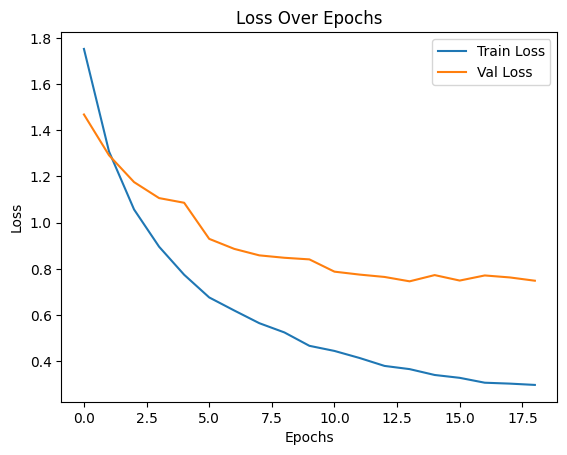

In [ ]:


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [21]:
# test accurecy
loss, acc = model.evaluate(test_data)
print(f"Test Accuracy: {acc * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.8945 - loss: 0.3109
Test Accuracy: 87.30%


In [22]:
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


<Figure size 1000x800 with 0 Axes>

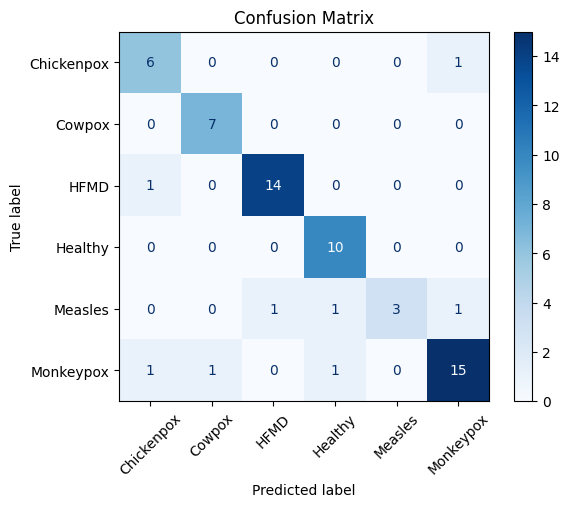

In [23]:
## confusion matrix

# 🔹 Step 2: Get true labels
y_true = test_data.classes

# 🔹 Step 3: Get class -names
class_names = list(test_data.class_indices.keys())

# 🔹 Step 4: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# 🔹 Step 5: Plot
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()




In [24]:
# 🔹 Step 6 (optional): Classification Report
print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))



📋 Classification Report:

              precision    recall  f1-score   support

  Chickenpox       0.75      0.86      0.80         7
      Cowpox       0.88      1.00      0.93         7
        HFMD       0.93      0.93      0.93        15
     Healthy       0.83      1.00      0.91        10
     Measles       1.00      0.50      0.67         6
   Monkeypox       0.88      0.83      0.86        18

    accuracy                           0.87        63
   macro avg       0.88      0.85      0.85        63
weighted avg       0.88      0.87      0.87        63



In [25]:
# Define a filename for your saved model
model_filename = 'my_mpox_skin_lesion_model.h5'

# Save the model
model.save(model_filename)

print(f"Model saved successfully to {model_filename}")

Model saved successfully to my_mpox_skin_lesion_model.h5


In [44]:
from tensorflow.keras.models import load_model

model = load_model(
    "/content/drive/MyDrive/test data/my_mpox_skin_lesion_model.h5",
)


In [45]:
from tensorflow.keras.preprocessing import image

img_path = "/content/drive/MyDrive/test data/test3.jpg"  # Path to your test image
img = image.load_img(img_path, target_size=(224, 224))  # Use your input size
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalization if done during training
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension


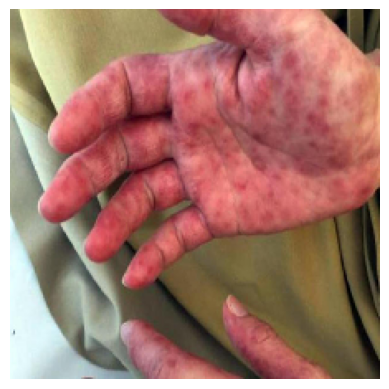

In [46]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [47]:
# Get the list of class names from the test data generator
class_names = list(test_data.class_indices.keys())

print("List of class names:")
print(class_names)

List of class names:
['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles', 'Monkeypox']


In [48]:
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
print("Predicted class index:", class_names[predicted_class[0]])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class index: HFMD


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
